# Lagaris Problem 1: 1st-Order Linear ODE IVP

## Setup

In [1]:
from math import exp, sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## The differential equation and analytical solution

The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
\frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

Rewritten in standard form:

\begin{equation}
G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The domain is $[0,1]$. The initial condition is:

\begin{equation}
\psi(0)=1
\end{equation}

The analytical solution and its first derivative are:

\begin{equation}
\psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

\begin{equation}
\frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

In [3]:
def yaf(x):
    return x**2 + exp(-x**2/2)/(1 + x + x**3)

def dya_dxf(x):
    return 2*x - exp(-x**2/2)*(1 + x + 4*x**2 + x**4)/(1 + x + x**3)**2

In [4]:
x = np.linspace(0, 2, 201)
ya = np.vectorize(yaf)(x)
dya_dx = np.vectorize(dya_dxf)(x)

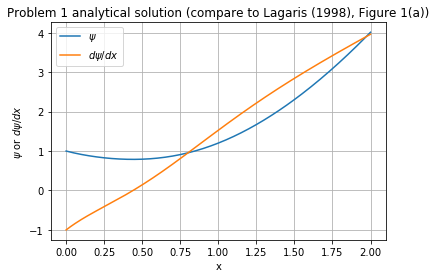

In [5]:
plt.plot(x, ya, label = "$\psi$")
plt.plot(x, dya_dx, label = "$d\psi/dx$")
plt.xlabel("x")
plt.ylabel("$\psi$ or $d\psi/dx$")
plt.grid()
plt.legend()
plt.title("Problem 1 analytical solution (compare to Lagaris (1998), Figure 1(a))");

## Solving the differential equation using a neural network

Create the differential equation object:

In [6]:
# Define the original differential equation.
def G(x, y, dy_dx):
    return  (
        dy_dx + (x + (1 + 3*x**2)/(1 + x + x**3))*y
        - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
    )

# Define the y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx):
    return x + (1 + 3*x**2)/(1 + x + x**3)

# Define the dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx):
    return 1

# Initial condition
A = 1

In [7]:
from ode1ivp import ODE1IVP
ode = ODE1IVP()
ode.Gf = G
ode.dG_dyf = dG_dy
ode.dG_dydxf = dG_dydx
ode.ic = A
ode.yaf = ya
ode.dya_dxf = dya_dx

Create the training data.

In [8]:
xmin = 0
xmax = 1
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Train the network.

In [9]:
from nnode1ivp import NNODE1IVP
np.random.seed(0)
net = NNODE1IVP(ode)
net.train(xt)

Compute the solution at the training points.

In [10]:
yt = np.vectorize(net.run)(xt)
dyt_dx = np.vectorize(net.run_derivative)(xt)

Plot the solution (note that only the range $[0,1]$ is examined).

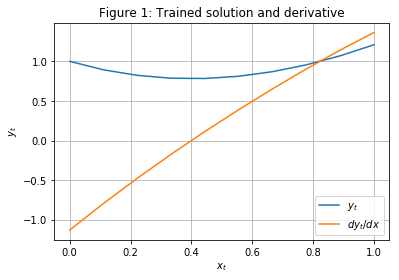

In [11]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.grid()
plt.legend()
plt.title("Figure 1: Trained solution and derivative");

Plot the error in the trained solution.

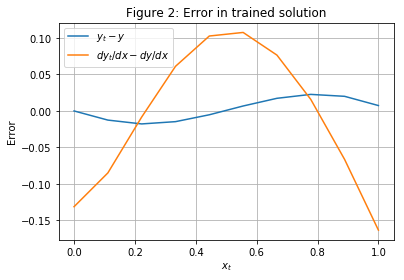

In [12]:
y = np.vectorize(yaf)(xt)
dy_dx = np.vectorize(dya_dxf)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Figure 2: Error in trained solution");

## Determine the optimal model parameters

The quality of the solution will vary with the model parameters: number of training points, number of hidden nodes, number of training epochs, learning rate, and network parameter ranges. Each of these aspects will be explored in isolation below.

### Number of training points

5 0.011897863914443283 0.073611916970927
10 0.01046177536425634 0.06897422150554683
20 0.01227221063083612 0.08365877317306941
40 0.145817540163868 0.5151016235786287
80 0.1762889645238126 0.7709540998606063
160 0.969974835940748 1.7610095891487487
320 0.9707090363962148 1.7567950274926618


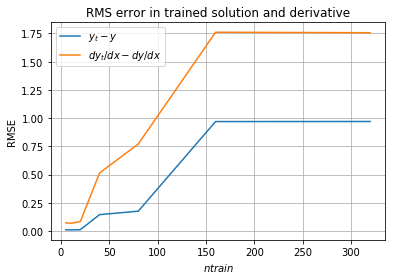

In [32]:
ntrains = [5, 10, 20, 40, 80, 160, 320]
n = len(ntrains)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)
for (i, ntrain) in enumerate(ntrains):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)
    
    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)
    
    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    net.train(xt, clamp = True)  # Clamp to prevent overflow.

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(ntrain, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(ntrains, rmse_yt, label = '$y_t-y$')
plt.plot(ntrains, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$ntrain$')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.title("RMS error in trained solution and derivative");

With this initial range of training set sizes, and default values for the other parameters, the optimal training set size is 10.

### Number of hidden nodes

5 0.03514789564647913 0.12644387299856705
10 0.01046177536425634 0.06897422150554683
20 0.01456831542462682 0.09567204129380168
40 0.021411656710181404 0.14076650786794281
80 0.17668026181515922 0.8066115998324036
160 13.92610377537237 23.216536514075074
320 27.91345670096654 46.67602175468231


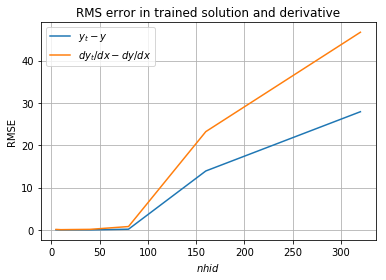

In [36]:
nhids = [5, 10, 20, 40, 80, 160, 320]
n = len(nhids)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)

ntrain = 10

for (i, nhid) in enumerate(nhids):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)

    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)

    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    net.train(xt, nhid = nhid, clamp = True)  # Clamp to prevent overflow.

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(nhid, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(nhids, rmse_yt, label = '$y_t-y$')
plt.plot(nhids, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$nhid$')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title("RMS error in trained solution and derivative");

At this point, the optimal number of hidden nodes is 10, which is the same as the number of training points.

### Number of training epochs

100 0.080237907061072 0.35146011671437216
500 0.011614781139285666 0.07681199622260054
1000 0.010235368519397945 0.06701813870368994
2000 0.009130733203265684 0.059370908654625965
4000 0.010103300130489816 0.06731621070972818
8000 0.005703921355654386 0.0363205823672252
16000 0.005940255175164299 0.038339896349275336


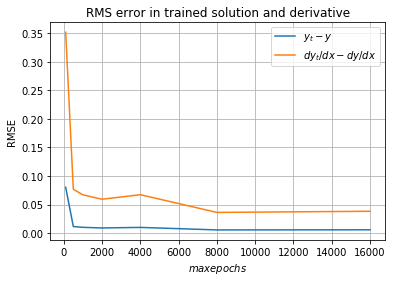

In [37]:
maxepochs_list = [100, 500, 1000, 2000, 4000, 8000, 16000]
n = len(maxepochs_list)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)

ntrain = 10

for (i, maxepochs) in enumerate(maxepochs_list):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)

    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)

    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    net.train(xt, maxepochs = maxepochs, clamp = True)  # Clamp to prevent overflow.

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(maxepochs, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(maxepochs_list, rmse_yt, label = '$y_t-y$')
plt.plot(maxepochs_list, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$maxepochs$')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.title("RMS error in trained solution and derivative");

The optimal number of epochs is roughly 8000.

### Learning rate

0.001 0.009742138046201955 0.06356232385440874
0.005 0.007041166370352322 0.045583990111055364
0.01 0.006287151099206967 0.040550686082886124
0.05 0.053090617930703916 0.2720539239086172
0.1 0.22104832464719487 0.889389006874374


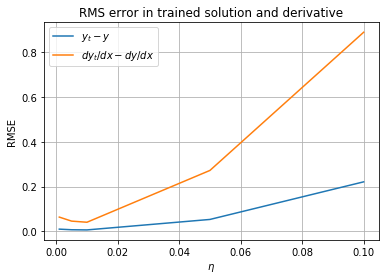

In [38]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
n = len(learning_rates)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)

ntrain = 10
maxepochs = 8000

for (i, eta) in enumerate(learning_rates):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)

    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)

    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    net.train(xt, maxepochs = maxepochs, eta = eta, clamp = True)  # Clamp to prevent overflow.

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(eta, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(learning_rates, rmse_yt, label = '$y_t-y$')
plt.plot(learning_rates, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$\eta$')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.title("RMS error in trained solution and derivative");

The optimal learning rate is approximately 0.1.

### Parameter ranges

The default parameter ranges are $[-1,+1]$. They can be adjusted up or down with optional arguments to the training method.

0.1 0.3409940631015826 0.8474259067770177
0.5 0.8292454532918281 1.6247050206152416
1 0.32071050065337203 0.9101651870217939
2 0.07029301405857975 0.3794328527244376
4 0.044848942436836146 0.09840778508580053
8 0.1114055256743475 0.45538623287283414


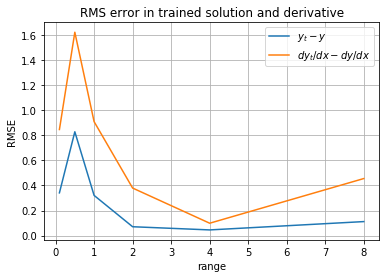

In [40]:
ranges = [0.1, 0.5, 1, 2, 4, 8]
n = len(ranges)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)

ntrain = 10
maxepochs = 8000
eta = 0.1

for (i, r) in enumerate(ranges):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)

    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)

    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    net.train(xt, maxepochs = maxepochs, eta = eta,
              wmin = -r, wmax = r, umin = -r, umax = r, vmin = -r, vmax = r,
              clamp = True)  # Clamp to prevent overflow.

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(r, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(ranges, rmse_yt, label = '$y_t-y$')
plt.plot(ranges, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('range')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.title("RMS error in trained solution and derivative");

The optimal parameter range is $[-4,+4]$.

### Tuning summary

It is obvious that the model and network parameters are not independent - optimal values for a given parameter change as the values of the other parameters change. The best set for a given problem must be found by experimentation.